# Calculation of control fields for symplectic dynamics using L-BFGS-B algorithm

Alexander Pitchford (agp1@aber.ac.uk)

Example to demonstrate using the control library to determine control
pulses using the ctrlpulseoptim.optimize_pulse function.
The (default) L-BFGS-B algorithm is used to optimise the pulse to
minimise the fidelity error, which in this case is given by the
'Trace difference' norm.

This in a Symplectic quantum system example, with two coupled oscillators

The user can experiment with the timeslicing, by means of changing the
number of timeslots and/or total time for the evolution.
Different initial (starting) pulse types can be tried.
The initial and final pulses are displayed in a plot

This example assumes that the example-control-pulseoptim-Hadamard has already been tried, and hence explanations in that notebook are not repeated here.

In [1]:
%matplotlib inline
import datetime

import matplotlib.pyplot as plt
import numpy as np
# QuTiP control modules
import qutip_qtrl.pulseoptim as cpo
import qutip_qtrl.symplectic as sympl
from qutip import Qobj, identity

example_name = "Symplectic"

### Defining the physics

In [3]:
# Drift
w1 = 1
w2 = 1
g1 = 0.5
A0 = Qobj(np.array([[w1, 0, g1, 0], [0, w1, 0, g1], [g1, 0, w2, 0], [0, g1, 0, w2]]))

# Control
Ac = Qobj(
    np.array(
        [
            [
                1,
                0,
                0,
                0,
            ],
            [0, 1, 0, 0],
            [0, 0, 0, 0],
            [0, 0, 0, 0],
        ]
    )
)
ctrls = [Ac]
n_ctrls = len(ctrls)

initial = identity(4)

# Target
a = 1
Ag = np.array([[0, 0, a, 0], [0, 0, 0, a], [a, 0, 0, 0], [0, a, 0, 0]])

Sg = Qobj(sympl.calc_omega(2).dot(Ag)).expm()

### Defining the time evolution parameters

In [4]:
# Number of time slots
n_ts = 1000
# Time allowed for the evolution
evo_time = 10

### Set the conditions which will cause the pulse optimisation to terminate

In [5]:
# Fidelity error target
fid_err_targ = 1e-10
# Maximum iterations for the optisation algorithm
max_iter = 500
# Maximum (elapsed) time allowed in seconds
max_wall_time = 30
# Minimum gradient (sum of gradients squared)
# as this tends to 0 -> local minima has been found
min_grad = 1e-20

### Set the initial pulse type

In [6]:
# pulse type alternatives: RND|ZERO|LIN|SINE|SQUARE|SAW|TRIANGLE|
p_type = "ZERO"

### Give an extension for output files

In [7]:
# Set to None to suppress output files
f_ext = "{}_n_ts{}_ptype{}.txt".format(example_name, n_ts, p_type)

### Run the optimisation

In [8]:
# Note that this call uses
#    dyn_type='SYMPL'
# This means that matrices that describe the dynamics are assumed to be
# Symplectic, i.e. the propagator can be calculated using
# expm(combined_dynamics.omega*dt)
# This has defaults for:
#    prop_type='FRECHET'
# therefore the propagators and their gradients will be calculated using the
# Frechet method, i.e. an exact gradient
#    fid_type='TRACEDIFF'
# so that the fidelity error, i.e. distance from the target, is give
# by the trace of the difference between the target and evolved operators
result = cpo.optimize_pulse(
    A0,
    ctrls,
    initial,
    Sg,
    n_ts,
    evo_time,
    fid_err_targ=fid_err_targ,
    min_grad=min_grad,
    max_iter=max_iter,
    max_wall_time=max_wall_time,
    dyn_type="SYMPL",
    out_file_ext=f_ext,
    init_pulse_type=p_type,
    gen_stats=True,
)

### Report the results

In [9]:
result.stats.report()
print("Final evolution\n{}\n".format(result.evo_full_final))
print("********* Summary *****************")
print("Final fidelity error {}".format(result.fid_err))
print("Final gradient normal {}".format(result.grad_norm_final))
print("Terminated due to {}".format(result.termination_reason))
print("Number of iterations {}".format(result.num_iter))
print(
    "Completed in {} HH:MM:SS.US".format(datetime.timedelta(seconds=result.wall_time))
)


------------------------------------
---- Control optimisation stats ----
**** Timings (HH:MM:SS.US) ****
Total wall time elapsed during optimisation: 0:00:02.809863
Wall time computing Hamiltonians: 0:00:00.120624 (4.29%)
Wall time computing propagators: 0:00:02.360108 (83.99%)
Wall time computing forward propagation: 0:00:00.021711 (0.77%)
Wall time computing onward propagation: 0:00:00.025040 (0.89%)
Wall time computing gradient: 0:00:00.225774 (8.04%)

**** Iterations and function calls ****
Number of iterations: 8
Number of fidelity function calls: 14
Number of times fidelity is computed: 14
Number of gradient function calls: 13
Number of times gradients are computed: 13
Number of times timeslot evolution is recomputed: 14

**** Control amplitudes ****
Number of control amplitude updates: 13
Mean number of updates per iteration: 1.625
Number of timeslot values changed: 13000
Mean number of timeslot changes per update: 1000.0
Number of amplitude values changed: 13000
Mean number o

### Plot the initial and final amplitudes

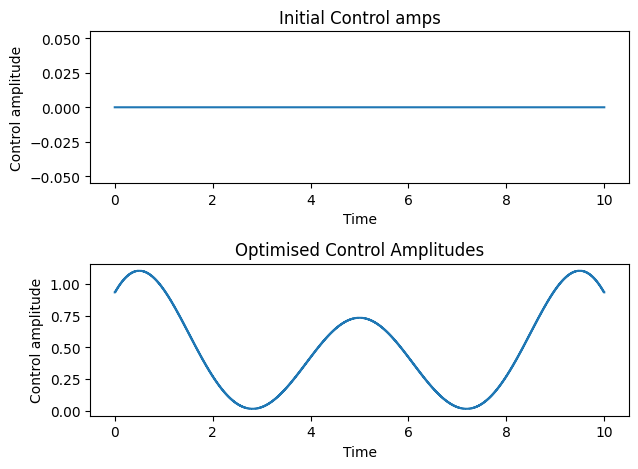

In [10]:
fig1 = plt.figure()
ax1 = fig1.add_subplot(2, 1, 1)
ax1.set_title("Initial Control amps")
ax1.set_xlabel("Time")
ax1.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax1.step(
        result.time,
        np.hstack((result.initial_amps[:, j], result.initial_amps[-1, j])),
        where="post",
    )

ax2 = fig1.add_subplot(2, 1, 2)
ax2.set_title("Optimised Control Amplitudes")
ax2.set_xlabel("Time")
ax2.set_ylabel("Control amplitude")
for j in range(n_ctrls):
    ax2.step(
        result.time,
        np.hstack((result.final_amps[:, j], result.final_amps[-1, j])),
        where="post",
    )

plt.tight_layout()
plt.show()

### Versions

In [11]:
from qutip.ipynbtools import version_table

version_table()

Software,Version
QuTiP,5.1.0.dev0+0b4260e
Numpy,1.26.4
SciPy,1.13.0
matplotlib,3.9.0
Number of CPUs,8
BLAS Info,Generic
IPython,8.25.0
Python,"3.12.3 | packaged by Anaconda, Inc. | (main, May 6 2024, 19:46:43) [GCC 11.2.0]"
OS,posix [linux]
Cython,3.0.10
